In [ ]:
# Abigail Kahler
## Homework 1

In [1]:
import pandas as pd
import numpy as np
import os as os
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd
from sklearn.linear_model import LinearRegression
import contextily as ctx

### Download Net CDF historical time series for use in temperature plot
#### https://towardsdatascience.com/handling-netcdf-files-using-xarray-for-absolute-beginners-111a8ab4463f
### Download Gauges II USGS streamgage dataset for mapping
#### https://water.usgs.gov/GIS/metadata/usgswrd/XML/gagesII_Sept2011.xml 
### Download USA Rivers and Streams dataset for mapping
#### https://hub.arcgis.com/datasets/esri::usa-rivers-and-streams/data?geometry=-126.415%2C30.380%2C-96.906%2C36.781&page=3

### Functions for generating forecast and histogram

In [2]:
def single_forecast(model, x):
    """Function performing the forecast calculation, where
        model = model used to generate prediction
            (must be a log to log scale autoregression)
        x = starting value of streamflow, can be integer or float
            (input must be in natural log scale!)

        returns: a prediction
            (note the prediction is returned in natural log scale)
            (however, the result is printed in nonlog scale)
    """
    # makes a prediction (in log space)
    prediction = (model.intercept_ + model.coef_ * x)
    # prints a prediction (in arithmetic space)
    print('forecast value', np.exp(prediction).round(2))
    # returns prediction (in log space)
    return prediction


In [3]:
def hist(data_in):
    """This function generates two histograms based on the input of a dataset of
    streamflow stored in natural log format

    Abigail, put in train['flow']

    data_in = a series from a pandas dataframe
              containing streamflow data in log

    shows two histograms, one of the data represented in log space and
    the other represented in arithmetic space

    the purpose is to show how doing your autoregression with 'log' data helps
    to normalize the underlying data, and generate better fits to training data

    returns nothing

    """
    # Histogram of flow data in natural log space
    textstr1 = '\n'.join((
                        'The flow data have',
                        'a nearly normal distribution',
                        'in log space'))
    fig, ax = plt.subplots()
    ax.hist(data_in, bins=10)
    ax.set(xlabel='flow in natural log scale',
           ylabel='frequency', ylim=(0, 100))
    ax.text(0.4, 0.95, textstr1, transform=ax.transAxes, fontsize=14,
            verticalalignment='top')
    plt.show()

    # Histogram of flow data in natural log space
    textstr2 = '\n'.join((
                        'The flow data have',
                        'a very skewed distribution',
                        'in arithmetic space'))
    fig, ax = plt.subplots()
    ax.hist(np.exp(data_in), bins=10)
    ax.set(xlabel='flow in arithmetic scale',
           ylabel='frequency', ylim=(0, 100))
    ax.text(0.4, 0.95, textstr2, transform=ax.transAxes, fontsize=14,
            verticalalignment='top')
    plt.show()

### Access streamflow data directly from USGS website and convert to dataframe

In [11]:
# Input start and end dates
site = '09506000'
start = '1990-01-01'
# Last date available for 16 week forecast
end = '2020-11-29'

url = "https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=" + \
      site + "&referred_module=sw&period=&begin_date=" + start + \
      "&end_date=" + end
data = pd.read_table(url, skiprows=30, names=['agency_cd', 'site_no',
                                              'datetime', 'flow', 'code'],
                     parse_dates=['datetime'])

data['year'] = pd.DatetimeIndex(data['datetime']).year
data['month'] = pd.DatetimeIndex(data['datetime']).month
data['day'] = pd.DatetimeIndex(data['datetime']).dayofweek
data['dayofweek'] = pd.DatetimeIndex(data['datetime']).dayofweek

# Aggregate flow values to weekly
flow_weekly = data.resample("W", on='datetime').mean()

# Set flow_weekly to natural log
flow_weekly_log = np.log(flow_weekly)
flow_weekly_log['flow_tm1'] = flow_weekly_log['flow'].shift(1)

### Select years for training and fit the model

In [12]:
train = flow_weekly_log['2017-01-01':'2019-01-01'][['flow', 'flow_tm1']]
model = LinearRegression()
x = train['flow_tm1'].values.reshape(-1, 1)
y = train['flow'].values
model.fit(x, y)

r_sq = model.score(x, y)
print('coefficient of determination:', np.round(r_sq, 2))

coefficient of determination: 0.87


### Generating AR model for one and two week forecast

In [13]:
# Starting value
start_val = flow_weekly.flow[-3]

# starting value in natural log (needed for regression)
start_val_ln = np.log(start_val)

# create two week forecast (saved in natural log)
adjust = 1.05
print('one week')
first_forecast = single_forecast(model, start_val_ln*adjust)
print('two week')
second_forecast = single_forecast(model, first_forecast*adjust)


one week
forecast value [195.96]
two week
forecast value [240.29]


### Generating 16 week forecast by setting a unique scaling factor for each four week increment

In [11]:
adjust = 1.0
sixteen_week_forecast = np.zeros(4)
for i in range(4):
    print('week',i+1)
    sixteen_week_forecast[i] = single_forecast(model, first_forecast * adjust)
    first_forecast = sixteen_week_forecast[i]
adjust = 1.01
sixteen_week_forecast2 = np.zeros(4)
for i in range(4):
    print('week',i+5)
    sixteen_week_forecast2[i] = single_forecast(model, first_forecast * adjust)
    first_forecast = sixteen_week_forecast2[i]
adjust = 1.03
sixteen_week_forecast3 = np.zeros(4)
for i in range(4):
    print('week',i+9)
    sixteen_week_forecast3[i] = single_forecast(model, first_forecast * adjust)
    first_forecast = sixteen_week_forecast3[i]
adjust = 1.02
sixteen_week_forecast4 = np.zeros(4)
for i in range(4):
    print('week',i+13)
    sixteen_week_forecast4[i] = single_forecast(model, first_forecast * adjust)
    first_forecast = sixteen_week_forecast4[i]

week 1
forecast value [60.81]
week 2
forecast value [65.55]
week 3
forecast value [70.16]
week 4
forecast value [74.62]
week 5
forecast value [82.05]
week 6
forecast value [89.49]
week 7
forecast value [96.88]
week 8
forecast value [104.18]
week 9
forecast value [121.12]
week 10
forecast value [139.4]
week 11
forecast value [158.93]
week 12
forecast value [179.61]
week 13
forecast value [192.09]
week 14
forecast value [204.38]
week 15
forecast value [216.44]
week 16
forecast value [228.21]


In [12]:
# Reading in the downloaded Gages II shapefile with geopandas
file = os.path.join('..\data', 'gagesII_9322_sept30_2011.shp')
gages = gpd.read_file(file)

# Reading in the downloaded USA Rivers and Streams shapefile with geopandas
file = os.path.join('..\data', '9ae73184-d43c-4ab8-940a-'\
    'c8687f61952f2020328-1-r9gw71.0odx9.shp')
usarivers = gpd.read_file(file)

In [13]:
# Select AZ streamgages, rivers, and the Verde River
gages_AZ=gages[gages['STATE']=='AZ']
azrivers = usarivers[usarivers['State']=='AZ']
verde = azrivers.loc[azrivers.Name=='Verde River']

# Reproject all layers to match gages crs
reproject_verde = verde.to_crs(gages.crs)
reproject_azrivers = azrivers.to_crs(gages.crs)

### This map is intended to be a tool for communicating with non-specialists; perhaps in an educational outreach program. It communicates the extent of rivers in streams in Arizona, which people outside of the state generalize as being consistently dry. While some of these streams are only seasonal, their existence is crucial to supporting ecosystems through seasonal cycles. For this project, the Verde River is highlighted within the big picture of all streams and gages. This overview can give insight into what other gages might be beneficial to include in the Verde streamflow forecast.

### The map image can be accessed in the submissions file under the name kahler_hw13_map.png

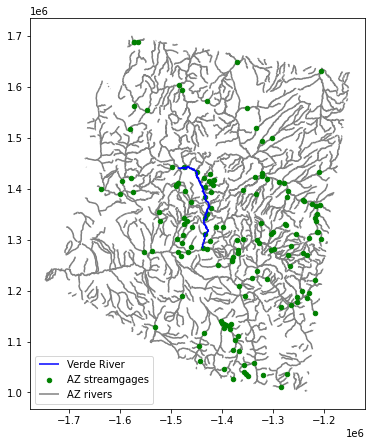

In [14]:
# Map featuring the Verde River within the context of AZ rivers and gages
fig, ax =plt.subplots(figsize=(6,8))
reproject_verde.plot(ax=ax, color = 'b', zorder = 3, label = 'Verde River')
gages_AZ.plot(markersize=20, c = 'g', zorder = 2,
              ax=ax, label = 'AZ streamgages')
reproject_azrivers.plot(ax=ax, color = 'gray', zorder = 1, label = 'AZ rivers')
ax.legend()
plt.show()